In [1]:
from IPython.display import FileLink, Image
import pandas as pd
import pandas.rpy.common as com
import brewer2mpl
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec
from matplotlib import collections
from numpy import nan, min, array
import itertools
from mpltools import style
style.use("ggplot")
%matplotlib inline
%load_ext rpy2.ipython

/opt/anaconda/lib/python2.7/site-packages/pandas/rpy/__init__.py:8: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2, found here: http://rpy.sourceforge.net
  "like rpy2, found here: http://rpy.sourceforge.net", FutureWarning)


In [2]:
%%R
library(phyloseq)
library(plyr); library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
%%R
physeq = import_biom("../data/otu_table_wtax.biom", "../data/otusn_phylum_constrained.tree")
sample.data = import_qiime_sample_data("../data/ABCD_combined_reads_mapper.tsv")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq.PS = prune_samples((physeq.md$Treatment %in% c("12CCPS","13CCPS","13CXPS"))&
                          !(row.names(physeq.md) %in% grep("bulk", row.names(physeq.md), value=TRUE)), physeq)

In [4]:
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["axes.edgecolor"] = "#151515"
matplotlib.rcParams["grid.color"] = "#959595"
matplotlib.rcParams["grid.alpha"] = "0.50"
matplotlib.rcParams["font.size"] = 7.5

In [9]:
def get_l2fc_df(df_fp, taxon, rank):
    df = pd.read_csv(df_fp, sep=",")
    df_subset = df[df[rank]==taxon]
    return df_subset, df_subset["OTU"]

def get_tree_df(physeq_str, OTUs):
    subset_fn_str = "prune_taxa(OTUs, %s)" %physeq_str
    %Rpush subset_fn_str
    %Rpush OTUs
    %R OTUs = as.character(OTUs)
    %R ps = eval(parse(text=subset_fn_str))
    %R tree_dfs = phyloseq:::tree_layout(phy_tree(ps), ladderize="right")
    %R tax = data.frame(tax_table(ps), stringsAsFactors = FALSE)
    %R tax$OTU = rownames(tax)
    %R tax[is.na(tax)] <- 'unassigned'
    %R edge_df = left_join(data.frame(tree_dfs$edgeDT), tax)
    %R edge_df$OTU = factor(edge_df$OTU)
    %R vert_df = data.frame(tree_dfs$vertDT)
    edge_df = com.load_data("edge_df")
    vert_df = com.load_data("vert_df")
    return edge_df, vert_df

def add_tree_info(tip_df, l2fc_df):
    l2fc_df = l2fc_df.merge(tip_df[["y","OTU"]], 
                            left_on="OTU", 
                            right_on="OTU")
    return l2fc_df

def get_tax_colordict(tip_df, color_rank):
    cats = set(tip_df[color_rank].dropna())
    c_list = []
    for m in ["Set3", "Dark2", "Accent", "Set1"]:
        colors = brewer2mpl.get_map(m, "qualitative", 8).hex_colors
        [c_list.append(c) for c in colors]
    color_dict = dict(itertools.izip(cats, itertools.cycle(c_list)))
    color_dict["unassigned"] = "#505050"
    return color_dict

def get_responders(l2fc_df, treatment):
    min_padj = l2fc_df[["OTU","padj","Treatment"]].groupby(["Treatment","OTU"]).min()
    t = min_padj["padj"]
    tmp = t[treatment]
    rsp = tmp[tmp<0.10].index.tolist()
    return rsp
    
def make_tree_fig(taxon, taxon_rank, color_rank, l2fc_fp, physeq_str, lw_tax = 3, leg_spacing = 0.25, 
                  save_fn = None, pt_size = 50):
    l2fc_df, otus = get_l2fc_df(l2fc_fp, taxon, taxon_rank)
    edge_df, vert_df = get_tree_df(physeq_str, otus.tolist())
    tip_df = edge_df[edge_df["OTU"].notnull()]
    l2fc_df = add_tree_info(tip_df, l2fc_df)
    tax_colors = get_tax_colordict(tip_df, color_rank)
    
    days = map(str,[1,3,7,14,30])
    scaleFactor = 0.125
    
    cell_rspdrs = get_responders(l2fc_df, "13CCPS")
    xyl_rspdrs = get_responders(l2fc_df, "13CXPS")

    df_pivot = l2fc_df.pivot_table(index = ["y"], columns=["Treatment","Day"], values="log2FoldChange")
    figHeight = min(array([df_pivot.shape[0]*scaleFactor, 30]))

    gs = gridspec.GridSpec(nrows=1, ncols=4, width_ratios=[6,2.25,4*.74,5*.75])

    fig = plt.figure()
    fig.set_size_inches((5,figHeight))
    #fig.set_size_inches((8,20))
    fig.subplots_adjust(wspace=0.05)

    cm = brewer2mpl.get_map('RdYlBu', 'diverging', 5, reverse=True).mpl_colormap

    edge_segments = edge_df.apply(lambda row: [(row["xleft"], row["y"]-1), (row["xright"], row["y"]-1)], axis = 1).values
    edge_collection = collections.LineCollection(segments = edge_segments, color="k", linewidths = 1.5)
    
    vert_segments = vert_df.apply(lambda row: [(row["x"], row["vmin"]-1), (row["x"], row["vmax"]-1)], axis = 1).values
    vert_collection = collections.LineCollection(segments = vert_segments, color="k", linewidths = 1.5)

    max_right = tip_df["xright"].max() * 1.05
    buff = 0.025
    verts = tip_df.apply(lambda row: [(row["xright"] + buff, row["y"] - 1.5), 
                                      (row["xright"] + buff, row["y"] - 0.5),
                                      (max_right, row["y"] - 0.5), 
                                      (max_right, row["y"] - 1.5)], axis = 1).values
    rect_collection = collections.PolyCollection(verts, 
                                             facecolors = tip_df.apply(lambda x: tax_colors[x[color_rank]], axis = 1),
                                             alpha = 0.75)
    
    ax1 = fig.add_subplot(gs[0])
    ax1.add_collection(edge_collection)
    ax1.add_collection(vert_collection)
    ax1.add_collection(rect_collection)
    ax1.set_xlim(edge_df["xleft"].min() - edge_df["xright"].max() * 0.05, edge_df["xright"].max() * 1.05)
    ax1.set_ylim(edge_df["y"].min() - edge_df["y"].max() * 0.05, edge_df["y"].max() * 1.05)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_frame_on(False)
    ax1.grid(False)
    ax1.set_title(taxon, fontdict = {"fontsize": 14})

    ax2 = fig.add_subplot(gs[1], sharey = ax1)
    criterion2 = tip_df["OTU"].map(lambda x: x in cell_rspdrs)
    criterion3 = tip_df["OTU"].map(lambda x: x in xyl_rspdrs)
    cell_rspndrs_tips = tip_df[criterion2]
    xyl_rspndrs_tips = tip_df[criterion3]
    ax2.scatter(x = [1 for i in cell_rspndrs_tips.y], 
                y = cell_rspndrs_tips.y -1, 
                s = pt_size, zorder = 100, color = "#377eb8")
    ax2.scatter(x = [2 for i in xyl_rspndrs_tips.y], 
                y = xyl_rspndrs_tips.y -1, 
                s = pt_size, zorder = 100, color = "#4daf4a")
    ax2.set_frame_on(False)
    ax2.set_xlim([0,3])
    ax2.set_xticks([1,2])
    ax2.set_xticklabels(["13CCPS","13CXPS"], rotation = 90, ha = "left", size = 8)
    ax2.set_yticks([])
    
    vmin = l2fc_df["log2FoldChange"].quantile(0.025)
    vmax = l2fc_df["log2FoldChange"].quantile(0.975)

    ax3 = fig.add_subplot(gs[2], sharey = ax1)
    ax3.set_xticks(range(len(days[1:])))
    ax3.set_xticklabels(days[1:])
    ax3.set_yticklabels([])
    ax3.set_title("13CCPS")
    ax3.set_xlabel("Day")
    df = df_pivot["13CCPS"]
    im = ax3.imshow(df.as_matrix(), interpolation="nearest", aspect="auto", cmap=cm, vmax=vmax, vmin=vmin)
    ax3.grid(False)

    ax4 = fig.add_subplot(gs[3], sharey = ax1)
    ax4.set_xticks(range(len(days)))
    ax4.set_xticklabels(days)
    ax4.set_yticklabels([])
    ax4.set_title("13CXPS")
    ax4.set_xlabel("Day")
    df = df_pivot["13CXPS"]
    ax4.imshow(df.as_matrix(), interpolation="nearest", aspect="auto", cmap=cm, vmax=vmax, vmin=vmin)
    ax4.grid(False)

    box = ax4.get_position()
    cax = fig.add_axes([box.xmax + 0.05, box.ymin + 2 * box.height / 3, 0.02, box.height / 3])
    cb = fig.colorbar(im, cax = cax)
    cb.set_label(r"log$_{2}$ Fold Change")

    proxy_artists = [plt.Rectangle((0,0),1,1,fc=tax_colors[i],alpha=0.75) 
                     for i in tip_df.sort("y")[color_rank].unique().tolist()]
    leg = ax1.legend(proxy_artists, 
                     tip_df.sort("y")[color_rank].unique().tolist(),
                     bbox_to_anchor = (0, -leg_spacing),
                     loc = 2, ncol = 2,
                     prop={'size':10,'style':"italic"}, labelspacing = 0.2)
    leg.set_frame_on(False)
    
    if save_fn:
        fig.savefig(save_fn, bbox_extra_artists=(leg, cax), bbox_inches='tight')

Joining by: "OTU"


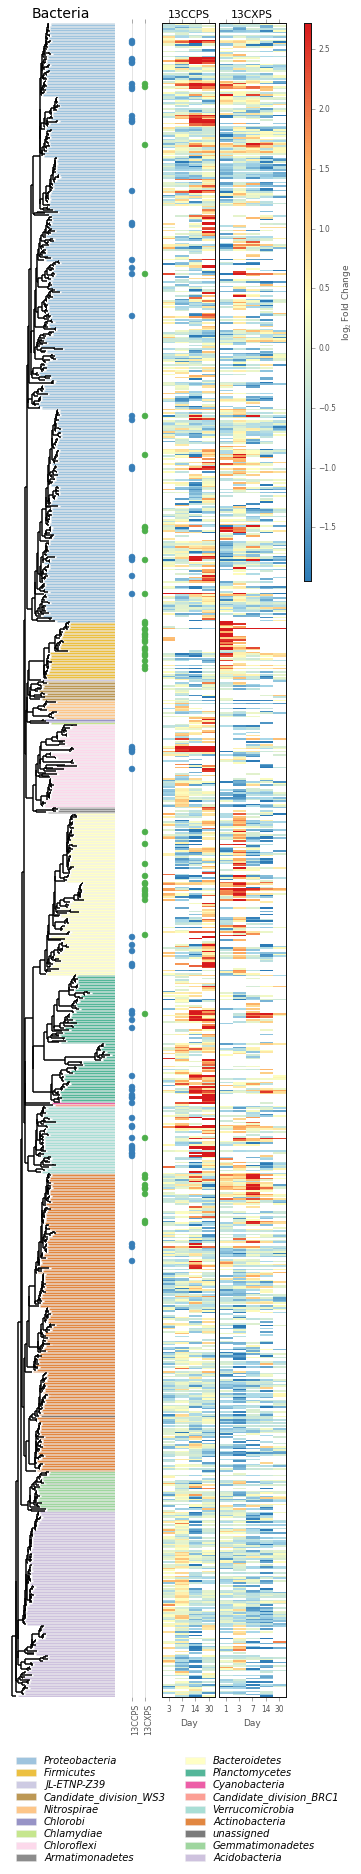

In [10]:
make_tree_fig("Bacteria", "Rank1", "Rank2", "../data/l2fc_table.csv", "physeq.PS", 
              save_fn = "figs/bacteria_tree.pdf", lw_tax = 1, leg_spacing = 0.03,
              #save_fn = None, lw_tax = 1, leg_spacing = 0.03,
              pt_size = 35)

In [11]:
FileLink("figs/bacteria_tree.pdf")

/home/chuck/working/CSIP_succession_data_analysis/figures_and_stats/figs/bacteria_tree.pdf

Joining by: "OTU"


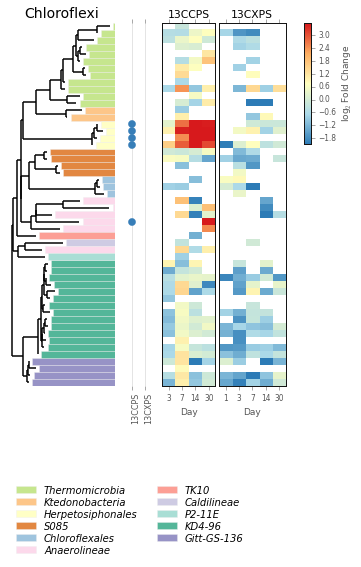

In [12]:
make_tree_fig("Chloroflexi", "Rank2", "Rank3", "../data/l2fc_table.csv", "physeq.PS", 
              save_fn="figs/chloroflexi_tree.pdf")

In [35]:
FileLink("figs/chloroflexi_tree.pdf")

/home/chuck/working/CSIP_succession_data_analysis/figures_and_stats/figs/chloroflexi_tree.pdf

Joining by: "OTU"


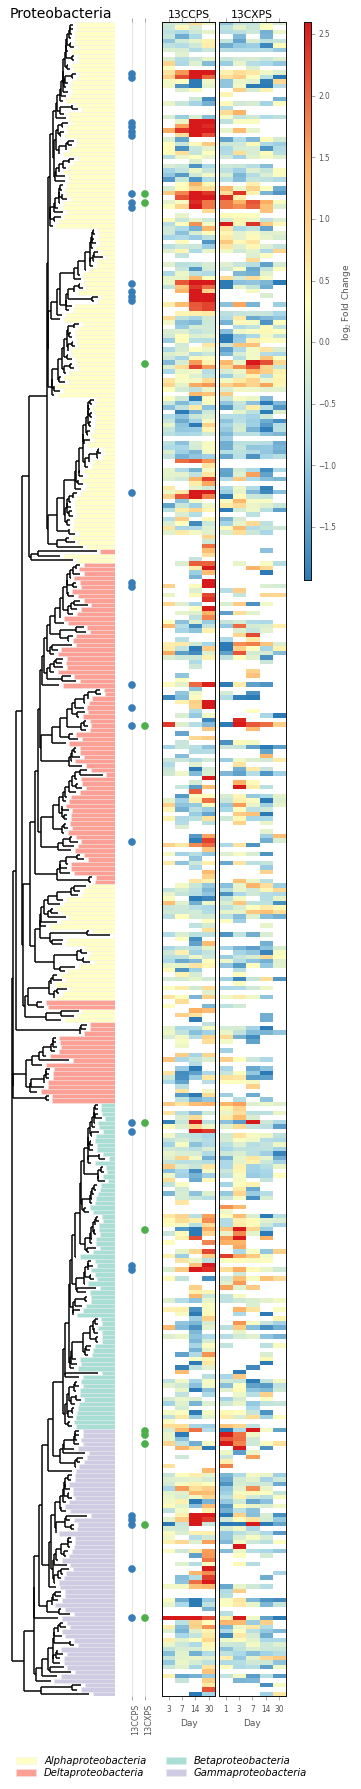

In [13]:
make_tree_fig("Proteobacteria", "Rank2", "Rank3", "../data/l2fc_table.csv", "physeq.PS", 
              save_fn="figs/proteobacteria_tree.pdf", leg_spacing = 0.03)

In [14]:
FileLink("figs/proteobacteria_tree.pdf")

/home/chuck/working/CSIP_succession_data_analysis/figures_and_stats/figs/proteobacteria_tree.pdf

Joining by: "OTU"


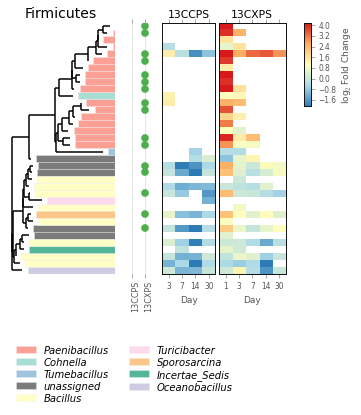

In [15]:
make_tree_fig("Firmicutes", "Rank2", "Rank6", "../data/l2fc_table.csv", "physeq.PS",
              save_fn = "figs/firmicutes_tree.pdf")

In [16]:
FileLink("figs/firmicutes_tree.pdf")

/home/chuck/working/CSIP_succession_data_analysis/figures_and_stats/figs/firmicutes_tree.pdf

Joining by: "OTU"


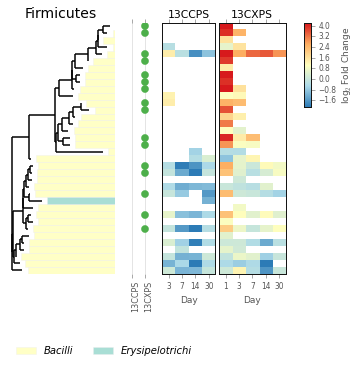

In [17]:
make_tree_fig("Firmicutes", "Rank2", "Rank3", "../data/l2fc_table.csv", "physeq.PS",
              save_fn = "figs/firmicutes2_tree.pdf")

Joining by: "OTU"


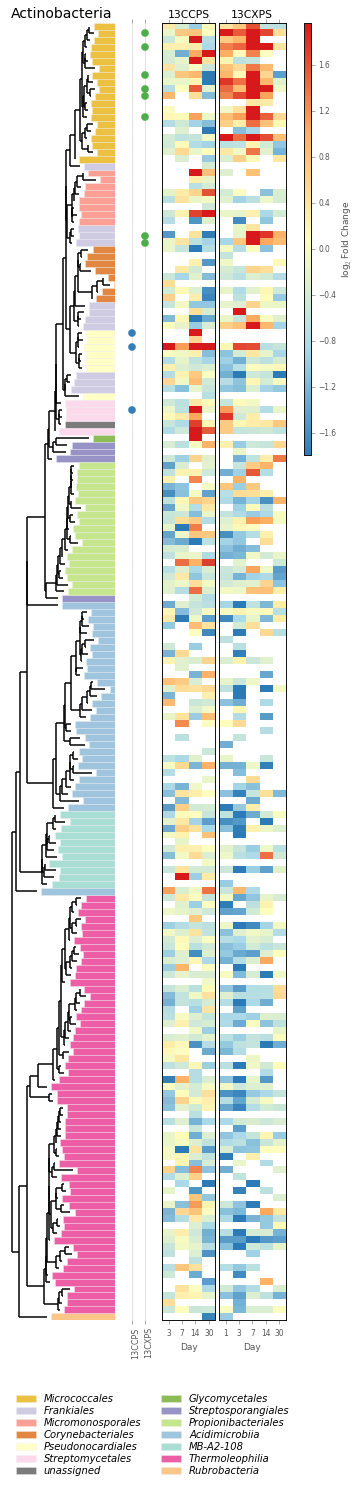

In [18]:
make_tree_fig("Actinobacteria", "Rank2", "Rank3", "../data/l2fc_table.csv", "physeq.PS",
              save_fn = "figs/actinobacteria_tree.pdf", leg_spacing = 0.05)

In [19]:
FileLink("figs/actinobacteria_tree.pdf")

/home/chuck/working/CSIP_succession_data_analysis/figures_and_stats/figs/actinobacteria_tree.pdf

Joining by: "OTU"


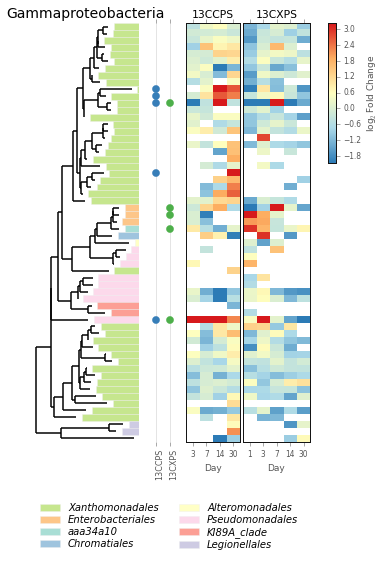

In [20]:
make_tree_fig("Gammaproteobacteria", "Rank3", "Rank4", "../data/l2fc_table.csv", "physeq.PS", leg_spacing = 0.125)

Joining by: "OTU"


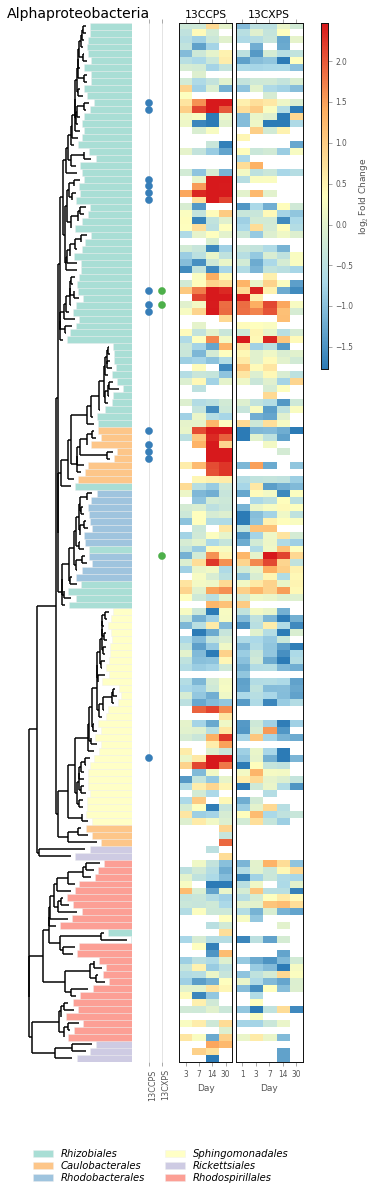

In [21]:
make_tree_fig("Alphaproteobacteria", "Rank3", "Rank4", "../data/l2fc_table.csv", "physeq.PS", leg_spacing = 0.075)

Joining by: "OTU"


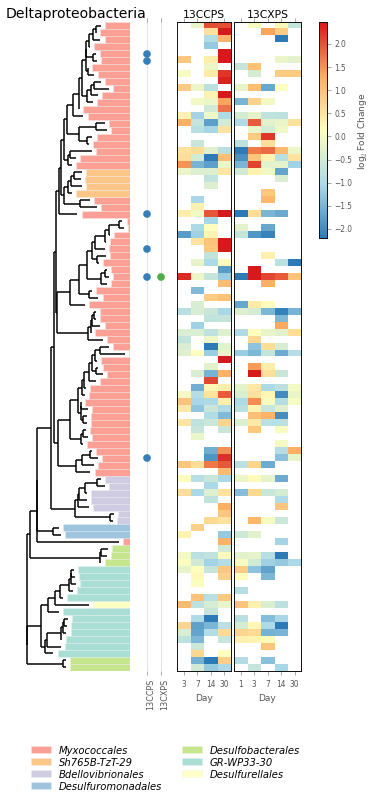

In [22]:
make_tree_fig("Deltaproteobacteria", "Rank3", "Rank4", "../data/l2fc_table.csv", "physeq.PS", leg_spacing = 0.1)

Joining by: "OTU"


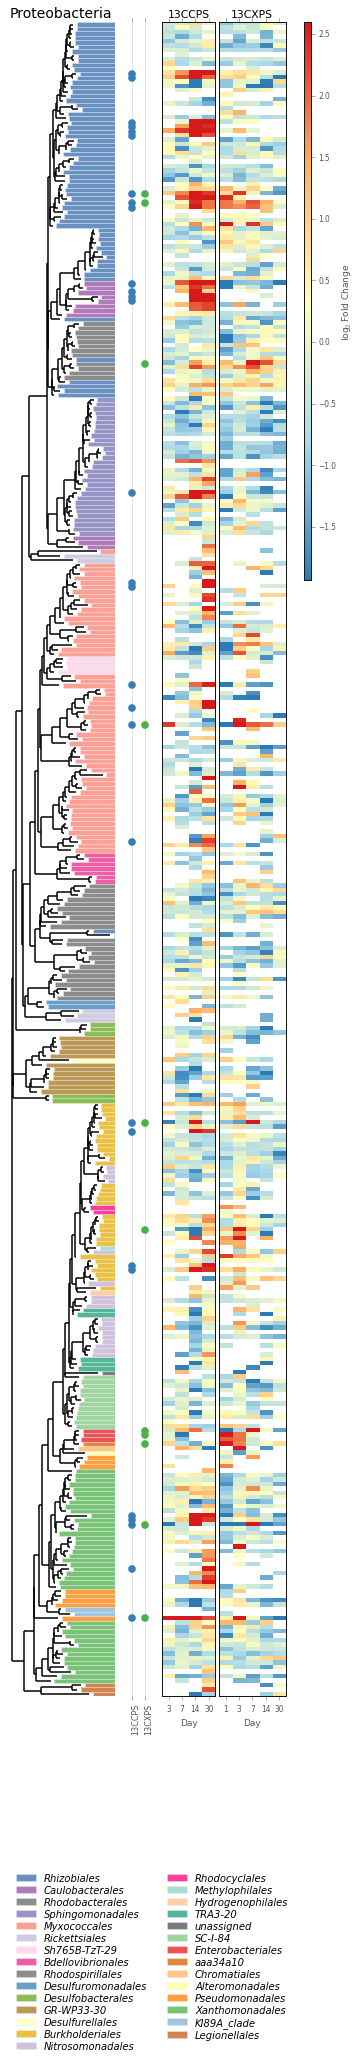

In [23]:
make_tree_fig("Proteobacteria", "Rank2", "Rank4", "../data/l2fc_table.csv", "physeq.PS", leg_spacing = 0.1)

Joining by: "OTU"


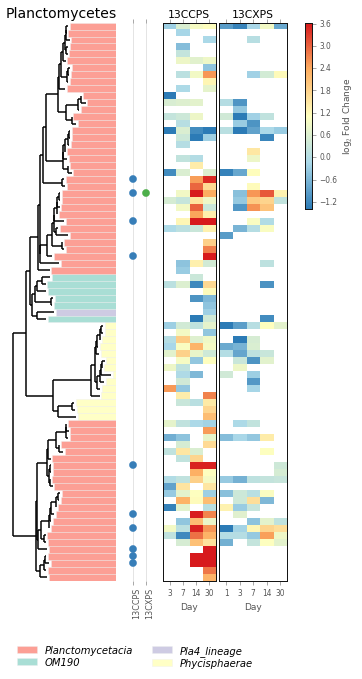

In [24]:
make_tree_fig("Planctomycetes", "Rank2", "Rank3", "../data/l2fc_table.csv", "physeq.PS", 
              save_fn = "figs/planctomycetes_tree.pdf", leg_spacing = 0.1)

Joining by: "OTU"


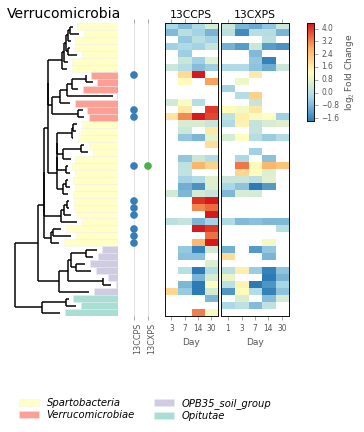

In [25]:
make_tree_fig("Verrucomicrobia", "Rank2", "Rank3", "../data/l2fc_table.csv", "physeq.PS", 
              save_fn="figs/verrucomicrobia_tree.pdf")

In [26]:
FileLink("figs/verrucomicrobia_tree.pdf")

/home/chuck/working/CSIP_succession_data_analysis/figures_and_stats/figs/verrucomicrobia_tree.pdf

Joining by: "OTU"


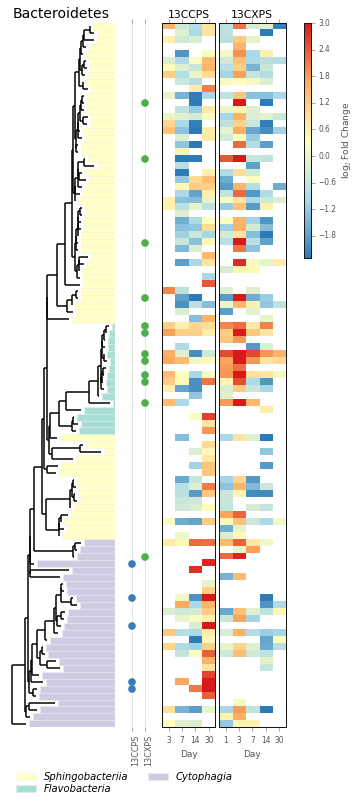

In [27]:
make_tree_fig("Bacteroidetes", "Rank2", "Rank3", "../data/l2fc_table.csv", "physeq.PS", 
              save_fn="figs/bacteroidetes_tree.pdf", leg_spacing = 0.05)

In [28]:
FileLink("figs/bacteroidetes_tree.pdf")

/home/chuck/working/CSIP_succession_data_analysis/figures_and_stats/figs/bacteroidetes_tree.pdf

In [29]:
col1 = " ".join(
[
        "figs/bacteroidetes_tree.pdf",
        "figs/chloroflexi_tree.pdf",
        "figs/planctomycetes_tree.pdf",
]
)
col1

'figs/bacteroidetes_tree.pdf figs/chloroflexi_tree.pdf figs/planctomycetes_tree.pdf'

In [30]:
!montage -mode concatenate -border 5 -density 300 -quality 100 -tile 1x $col1 \
figs/col1.pdf

In [31]:
col2 = " ".join(
[
        "figs/actinobacteria_tree.pdf",
        "figs/firmicutes_tree.pdf",
        "figs/verrucomicrobia_tree.pdf"
]
)
col2

'figs/actinobacteria_tree.pdf figs/firmicutes_tree.pdf figs/verrucomicrobia_tree.pdf'

In [32]:
!montage -mode concatenate -border 5 -density 300 -quality 100 -tile 1x $col2 \
figs/col2.pdf

In [33]:
!montage -mode concatenate -tile 3x -density 300 -quality 100 -border 5 figs/proteobacteria_tree.pdf \
figs/col2.png figs/col1.png figs/tiled_tree.pdf
#Image("figs/tiled_tree.png", width=800)

In [34]:
FileLink("figs/tiled_tree.pdf")

/home/chuck/working/CSIP_succession_data_analysis/figures_and_stats/figs/tiled_tree.pdf